In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

question: 1+2*2=?

answers:
    correct = 5
    incorrect answers = [6],[1,2,0,-4,100,...]
    
correct answers: theres only ope
incorrect answers: theres many, divide into two groups: 
    first, incorrect that could be feasibly confused with the correct answer (6 in this case)
    second, incorrect answers that are not really close at all (1,2,0,-4,100,...)
    


In [2]:
class Question():
    def __init__(self, perplexity = 0.0, uncertainty = 0.0):
        self.perplexity = perplexity 
        self.uncertainty = uncertainty
        # perplexity is a float between 0 and 1, 0 indicates no confounding answers exist, 1 indicates a single confounding answer dominates the correct answer
        # uncertainty is a float between 0 and 1, 0 indicates that a model presented with this question will always answer consistently, 1 indicates that a model presented with this question will always answer randomly
    
class Exam():
    def __init__(self, n_questions, perplexities, uncertainties):
        self.n_questions = n_questions
        self.perplexities = perplexities
        self.uncertainties = uncertainties
        
        if isinstance(self.perplexities, (int, float)):
            self.perplexities = [self.perplexities for i in range(n_questions)]
        if isinstance(self.uncertainties, (int, float)):
            self.uncertainties = [self.uncertainties for i in range(n_questions)]
        
        assert len(self.perplexities) == n_questions, 'provided perplexities list must have the same length as the number of questions'
        assert len(self.uncertainties) == n_questions, 'provided uncertainties list must have the same length as the number of questions'
        
        self.questions = [Question(d[0],d[1]) for d in zip(self.perplexities, self.uncertainties)]
            
class Agent():
    def __init__(self, competence = 1):
        self.competence = competence
        # competence is a float between 0 and 1, 0 indicates the model responds completely randomly, 1 indicates the model responds in line with its belief 100% of the time

    def answer(self, question):
        # return (np.random.binomial(p=1 - question.perplexity, n=1, ) * 2 - 1) * np.random.binomial(p=self.competence, n=1, ) # 1 if correct, -1 if confused, 0 if stochastic
        return (np.random.binomial(p=1 - question.perplexity, n=1, ) * 2 - 1) * np.random.binomial(p=1 - question.uncertainty, n=1, ) * np.random.binomial(p=self.competence, n=1, )# 1 if correct, -1 if confused, 0 if stochastic
    
    def take_exam(self, exam):
        return [self.answer(q) for q in exam.questions]
            
class Ensemble():
    def __init__(self, n_agents, competencies):
        self.n_agents = n_agents
        self.competencies = competencies
        
        if isinstance(self.competencies, (int, float)):
            self.agents = [Agent(competencies) for i in range(n_agents)]
        elif type(self.competencies) == list or type(self.competencies) == np.ndarray:
            assert len(self.competencies) == n_agents, 'provided competencies list must have the same length as the number of agents'
            self.agents = [Agent(c) for c in self.competencies]
        else:
            assert False, 'competencies must be either an number, a list or a numpy array'
                    
    def take_exam(self, exam):
        return [a.take_exam(exam) for a in self.agents]
    
    def vote(self, answers, threshold):
        answers = np.array(answers)
        consensus = np.mean(np.where(answers != 0, 1, 0), axis=0) >= threshold
        responses = np.where(np.mean(answers, axis=0) > 0, 1, 0)
        responses = np.where(np.mean(answers, axis=0) < 0, -1, responses)
        return responses * consensus
    
    def vote_count(self, responses):
        return [np.sum(np.array(responses) == i) for i in [-1, 0, 1]]
        

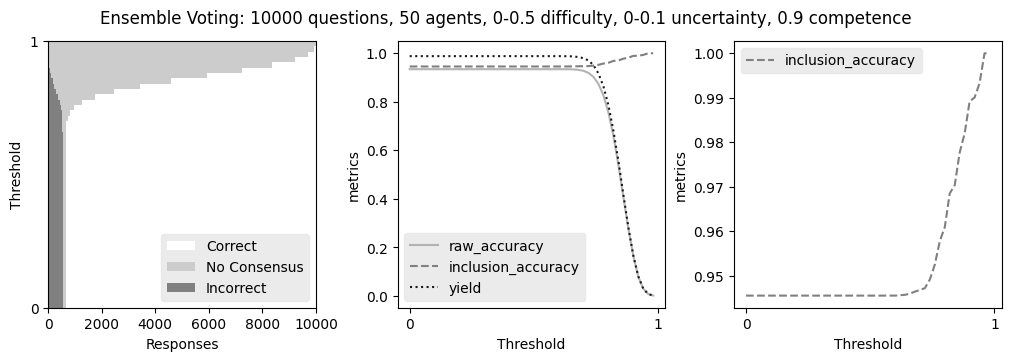

In [131]:
questions = 10000
agents = 50
thresholds = 50
perplexity = (0, 0.5)
uncertainty = (0, 0.1)
competence = 0.9

exam = Exam(questions, perplexities = np.linspace(perplexity[0],perplexity[1],questions), uncertainties = np.linspace(uncertainty[0],uncertainty[1],questions))
ensemble = Ensemble(n_agents = agents, competencies = competence)
ensemble_answers = ensemble.take_exam(exam)
values = [ensemble.vote_count(ensemble.vote(ensemble_answers, thresh)) for thresh in np.linspace(0, 1, thresholds)]

fig, ax = plt.subplots(1,3, figsize=(10,3.5), constrained_layout=True)
ax[0].stairs(np.array(values)[:,0] + np.array(values)[:,1] + np.array(values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(values)[:,0] + np.array(values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, questions])
ax[0].set_yticks([0, thresholds])
ax[0].set_yticklabels(['0', '1'])
ax[0].set_ylabel('Threshold')
ax[0].set_xlabel('Responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(np.array(values)[:,2] / (np.array(values)[:,0] + np.array(values)[:,1] + np.array(values)[:,2]), color=[0.7,0.7,0.7], label='raw_accuracy')
ax[1].plot(np.array(values)[:,2] / (np.array(values)[:,0] + np.array(values)[:,2]), color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[1].plot((np.array(values)[:,0] + np.array(values)[:,2]) / (np.array(values)[:,0] + np.array(values)[:,1] + np.array(values)[:,2]), color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('Threshold')
ax[1].set_xticks([0, thresholds])
ax[1].set_xticklabels(['0', '1'])
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(np.array(values)[:,2] / (np.array(values)[:,0] + np.array(values)[:,2]), color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('Threshold')
ax[2].set_xticks([0, thresholds])
ax[2].set_xticklabels(['0', '1'])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])


plt.suptitle(f'Ensemble Voting: {questions} questions, {agents} agents, {perplexity[0]}-{perplexity[1]} perplexity, {uncertainty[0]}-{uncertainty[1]} uncertainty, {competence} competence')
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:43<00:00,  6.13it/s]
/tmp/ipykernel_1675983/4010426495.py:17: RuntimeWarning: invalid value encountered in divide
  inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])


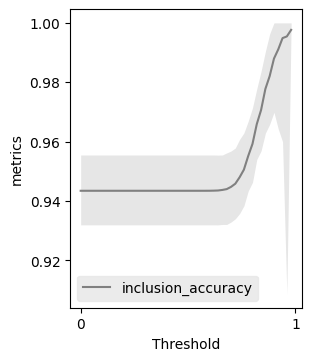

In [129]:
questions = 1000
agents = 50
thresholds = 50
perplexity = (0, 0.5)
uncertainty = (0, 0.1)
competence = 0.9

running_vals = []

for i in tqdm.tqdm(range(1000)):
    exam = Exam(questions, perplexities = np.linspace(perplexity[0],perplexity[1],questions), uncertainties = np.linspace(uncertainty[0],uncertainty[1],questions))
    ensemble = Ensemble(n_agents = agents, competencies = competence)
    ensemble_answers = ensemble.take_exam(exam)
    values = [ensemble.vote_count(ensemble.vote(ensemble_answers, thresh)) for thresh in np.linspace(0, 1, thresholds)]
    running_vals.append(values)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)
inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)

fig, ax = plt.subplots(1,1, figsize=(3,3.5), constrained_layout=True)
# ax.fill_between(np.arange(thresholds),
#                 inclusion_accuracy_mean - inclusion_accuracy_std,
#                 inclusion_accuracy_mean + inclusion_accuracy_std,
#                 color=[0.9,0.9,0.9], alpha=1, linewidth=0)
ax.fill_between(np.arange(thresholds),
                inclusion_accuracy_lower,
                inclusion_accuracy_upper,
                color=[0.9,0.9,0.9], alpha=1, linewidth=0)
ax.plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], label='inclusion_accuracy')
ax.set_ylabel('metrics')
ax.set_xlabel('Threshold')
ax.set_xticks([0, thresholds])
ax.set_xticklabels(['0', '1'])
ax.legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])
plt.show()

100%|██████████| 100/100 [00:16<00:00,  6.14it/s]
/tmp/ipykernel_1774959/1315313537.py:39: RuntimeWarning: invalid value encountered in divide
  inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
/tmp/ipykernel_1774959/1315313537.py:40: RuntimeWarning: Mean of empty slice
  inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)
/home/trevor/miniconda3/envs/ensembles/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/trevor/miniconda3/envs/ensembles/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


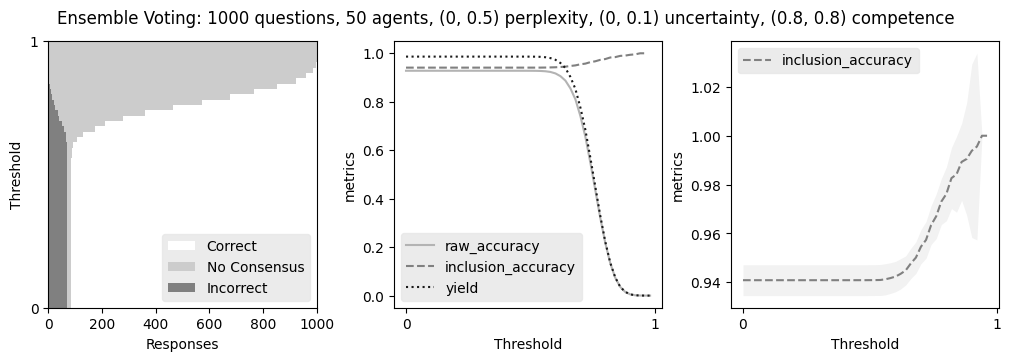

In [9]:
questions = 1000
agents = 50
thresholds = 50
perplexity = (0, 0.5)
uncertainty = (0, 0.1)
competence = (0.6, 1)

exam = Exam(questions, perplexities = np.linspace(perplexity[0],perplexity[1],questions), uncertainties = np.linspace(uncertainty[0],uncertainty[1],questions))
ensemble = Ensemble(n_agents = agents, competencies = np.random.uniform(competence[0], competence[1], agents))
ensemble_answers = ensemble.take_exam(exam)
values = [ensemble.vote_count(ensemble.vote(ensemble_answers, thresh)) for thresh in np.linspace(0, 1, thresholds)]

fig, ax = plt.subplots(1,3, figsize=(10,3.5), constrained_layout=True)
ax[0].stairs(np.array(values)[:,0] + np.array(values)[:,1] + np.array(values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(values)[:,0] + np.array(values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, questions])
ax[0].set_yticks([0, thresholds])
ax[0].set_yticklabels(['0', '1'])
ax[0].set_ylabel('Threshold')
ax[0].set_xlabel('Responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

running_vals = []
for i in tqdm.tqdm(range(100)):
    exam = Exam(questions, perplexities = np.linspace(perplexity[0],perplexity[1],questions), uncertainties = np.linspace(uncertainty[0],uncertainty[1],questions))
    ensemble = Ensemble(n_agents = agents, competencies = np.random.uniform(competence[0], competence[1], agents))
    ensemble_answers = ensemble.take_exam(exam)
    values = [ensemble.vote_count(ensemble.vote(ensemble_answers, thresh)) for thresh in np.linspace(0, 1, thresholds)]
    running_vals.append(values)
    
raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)

ax[1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('Threshold')
ax[1].set_xticks([0, thresholds])
ax[1].set_xticklabels(['0', '1'])
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('Threshold')
ax[2].set_xticks([0, thresholds])
ax[2].set_xticklabels(['0', '1'])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ax[2].fill_between(np.arange(thresholds),
#                 inclusion_accuracy_lower,
#                 inclusion_accuracy_upper,
#                 color=[0.9,0.9,0.9], alpha=1, linewidth=0)
ax[2].fill_between(np.arange(thresholds),
                inclusion_accuracy_mean - inclusion_accuracy_std,
                inclusion_accuracy_mean + inclusion_accuracy_std,
                color=[0.95,0.95,0.95], alpha=1, linewidth=0)

plt.suptitle(f'Ensemble Voting: {questions} questions, {agents} agents, {perplexity} perplexity, {uncertainty} uncertainty, {competence} competence')
plt.savefig(f'EnsembleVoting_q{questions}_a{agents}_d{perplexity[0]}-{perplexity[1]}_u{uncertainty[0]}-{uncertainty[1]}_c{competence[0]}-{competence[1]}.png', format='png', dpi=300)

In [8]:
questions = 1000
agents = 50
thresholds = 50
competence = (0.8, 0.8)
perplexity_uncertainty_mean = (0.5,0.5)
perplexity_uncertainty_covariance = 0.01*np.array([[1,0],[0,1]])

running_vals = []
for i in tqdm.tqdm(range(100)):
    perplexity_uncertainty = np.clip(np.random.multivariate_normal(perplexity_uncertainty_mean, perplexity_uncertainty_covariance, questions), 0, 1)
    exam = Exam(questions, perplexities = perplexity_uncertainty[:,0], uncertainties = perplexity_uncertainty[:,1])
    ensemble = Ensemble(n_agents = agents, competencies = np.random.uniform(competence[0], competence[1], agents))
    ensemble_answers = ensemble.take_exam(exam)
    values = [ensemble.vote_count(ensemble.vote(ensemble_answers, thresh)) for thresh in np.linspace(0, 1, thresholds)]
    running_vals.append(values)

mean_values = np.mean(np.array(running_vals), axis=0)

raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)


fig, ax = plt.subplots(1,4, figsize=(13,3.5), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, questions])
ax[0].set_yticks([0, thresholds])
ax[0].set_yticklabels(['0', '1'])
ax[0].set_ylabel('Threshold')
ax[0].set_xlabel('Responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('Threshold')
ax[1].set_xticks([0, thresholds])
ax[1].set_xticklabels(['0', '1'])
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[2].set_ylabel('metrics')
ax[2].set_xlabel('Threshold')
ax[2].set_xticks([0, thresholds])
ax[2].set_xticklabels(['0', '1'])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[3].scatter(perplexity_uncertainty[:,0], perplexity_uncertainty[:,1], s=1, c='k', alpha=0.2, label='question difficulty')
ax[3].set_xlabel('Perplexity')
ax[3].set_ylabel('Uncertainty')
ax[3].set_xlim([0, 1])
ax[3].set_ylim([0, 1])
ax[3].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ax[2].fill_between(np.arange(thresholds),
#                 inclusion_accuracy_lower,
#                 inclusion_accuracy_upper,
#                 color=[0.9,0.9,0.9], alpha=1, linewidth=0)
ax[2].fill_between(np.arange(thresholds),
                inclusion_accuracy_mean - inclusion_accuracy_std,
                inclusion_accuracy_mean + inclusion_accuracy_std,
                color=[0.95,0.95,0.95], alpha=1, linewidth=0)

plt.suptitle(f'Ensemble Voting: {questions} questions, {agents} agents, {competence} competence, perplexity uncertainty mean {perplexity_uncertainty_mean} and covariance {perplexity_uncertainty_covariance}', fontsize=8)
plt.savefig(f'EnsembleVoting_q{questions}_a{agents}_pumean{perplexity_uncertainty_mean}_pucov{perplexity_uncertainty_covariance}_c{competence[0]}-{competence[1]}.png', format='png', dpi=300)

 18%|█▊        | 18/100 [00:03<00:13,  6.11it/s]

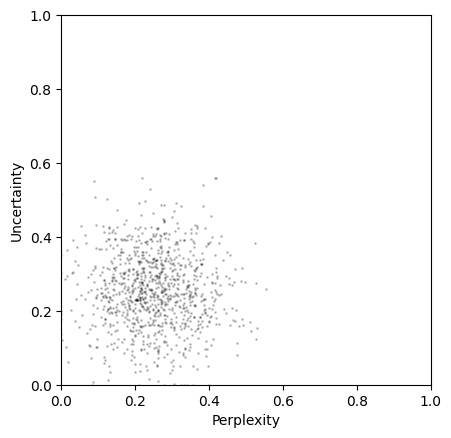

In [120]:
perplexity_uncertainty = np.clip(np.random.multivariate_normal([0.25,0.25], 0.01*np.array([[1,0],[0,1]]), questions), 0, 1)

plt.scatter(perplexity_uncertainty[:,0], perplexity_uncertainty[:,1], s=1, c='k', alpha=0.2, label='question difficulty')
plt.xlabel('Perplexity')
plt.ylabel('Uncertainty')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')